<a href="https://colab.research.google.com/github/nordm031/Keras_DL_SVC_SVM_KNN/blob/main/EE_8591_Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numba
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv

from time import time
from numba import cuda
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import display
from skimage.feature import hog
from skimage.color import rgb2grey
from google.colab import files

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

# Problem 2

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)   

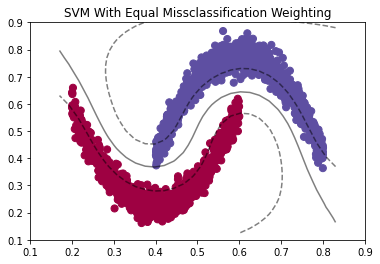

[[1002    0]
 [   0  998]]


In [ ]:
# Generating 2-dimensional hyperbolas data set

# Initializing Parameters
n_train = 50
n_val = 50
n_test = 1000
n_tot = n_train + n_val + n_test

t_1 = np.random.uniform(0.2, 0.6, (n_tot, 1))
t_2 = np.random.uniform(0.4, 0.8, (n_tot, 1))

# Generating Dataset
x_1 = ((t_1 - 0.4) * 3)**2 + 0.225 + np.random.normal(0, 0.03, (n_tot, 1))
x_2 = 1 - ((t_2 - 0.6) * 3)**2 - 0.225 + np.random.normal(0, 0.03, (n_tot, 1))
x1 = np.column_stack((t_1, x_1))
x2 = np.column_stack((t_2, x_2))
y_1 = np.zeros((n_tot, 1))
y_2 = np.ones((n_tot, 1))
X = np.vstack((x1, x2))
y = np.vstack((y_1, y_2))

# Splitting into training, validation, and testing sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=2000, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.5, random_state=69)

# Plotting Training Samples
#plt.figure()
#plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=50, cmap="Spectral")
#plt.xlim(0.1, 0.9)
#plt.ylim(0.1, 0.9)
#plt.show()

# Performing SVC (Equal Missclassification Errors)
C_vals = [2e-4, 2e-3, 2e-2, 2e-1, 2e0, 2e1, 2e2, 2e4, 2e5]
gamma_vals = [8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96]
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
score_temp = 0
C_best = 0
gamma_best = 0
for i in range(0, len(C_vals)):
  for j in range(0, len(gamma_vals)):
    params = {'C': C_vals[i], 'gamma': gamma_vals[j]}
    clf = SVC(kernel='rbf', **params)
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    if score > score_temp:
      score_temp = score
      C_best = C_vals[i]
      gamma_best = gamma_vals[j]

# Vizualizing Best SVC Model
params = {'C': C_best, 'gamma': gamma_best}
clf = SVC(kernel='rbf', **params)
clf = clf.fit(X_train, y_train)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=50, cmap="Spectral")
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none')
plt.xlim(0.1, 0.9)
plt.ylim(0.1, 0.9)
plt.title("SVM With Equal Missclassification Weighting")
plt.show()

y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

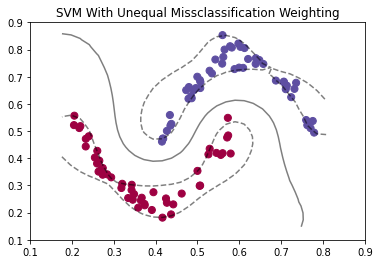

[[1001    1]
 [   3  995]]


In [ ]:
# Performing SVC (Unequal Missclassification Errors)
C_vals = [2e-2, 2e-1, 2e0, 2e1, 2e2, 2e4]
gamma_vals = [48, 56, 64, 72, 80, 88, 96]
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
score_temp = 0
C_best = 0
gamma_best = 0
for i in range(0, len(C_vals)):
  for j in range(0, len(gamma_vals)):
    params = {'C': C_vals[i], 'gamma': gamma_vals[j]}
    clf = SVC(kernel='rbf', **params, class_weight={0: 2, 1: 1})
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_val, y_val)
    if score > score_temp:
      score_temp = score
      C_best = C_vals[i]
      gamma_best = gamma_vals[j]

# Vizualizing Best SVC Model
params = {'C': C_best, 'gamma': gamma_best}
clf = SVC(kernel='rbf', **params)
clf = clf.fit(X_train, y_train)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=50, cmap="Spectral")
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none')
plt.xlim(0.1, 0.9)
plt.ylim(0.1, 0.9)
plt.title("SVM With Unequal Missclassification Weighting")
plt.show()

y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))

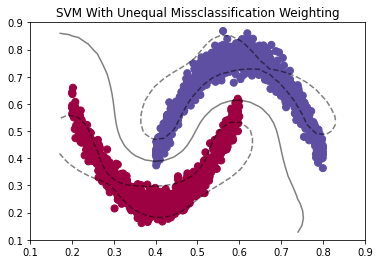

In [ ]:
# Vizualizing Best SVC Model
params = {'C': C_best, 'gamma': gamma_best}
clf = SVC(kernel='rbf', **params)
clf = clf.fit(X_train, y_train)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=50, cmap="Spectral")
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none')
plt.xlim(0.1, 0.9)
plt.ylim(0.1, 0.9)
plt.title("SVM With Unequal Missclassification Weighting")
plt.show()

# Problem 3

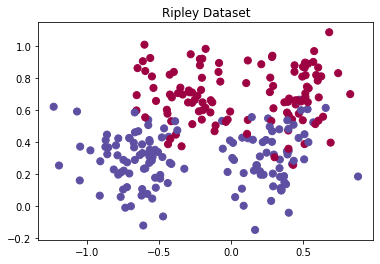

In [ ]:
## Part a: Ripley's Dataset ##

# Generating Dataset
n_train = 250
n_val = 250
n_test = 1000
n_tot = n_train + n_val + n_test

x_0_1 = np.random.multivariate_normal([-0.3, 0.7], [[0.03, 0], [0, 0.03]], (n_tot))
x_0_2 = np.random.multivariate_normal([0.4, 0.7], [[0.03, 0], [0, 0.03]], (n_tot))
x_1_1 = np.random.multivariate_normal([-0.7, 0.3], [[0.03, 0], [0, 0.03]], (n_tot))
x_1_2 = np.random.multivariate_normal([0.3, 0.3], [[0.03, 0], [0, 0.03]], (n_tot))

x1 = np.vstack((x_0_1, x_0_2))
x2 = np.vstack((x_1_1, x_1_2))
y_1 = np.zeros((n_tot*2, 1))
y_2 = np.ones((n_tot*2, 1))
X = np.vstack((x1, x2))
y = np.vstack((y_1, y_2))

# Splitting into training, validation, and testing sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=5500, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.5, random_state=69)

# Visualizing Dataset (Training Set)
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=50, cmap="Spectral")
plt.title('Ripley Dataset')
plt.show()


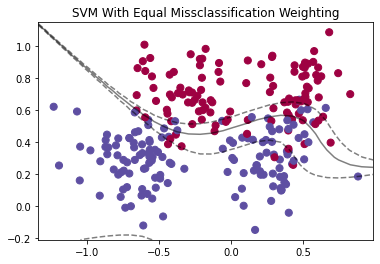

Polynomial SVM
Optimal degree is: 4
Optimal C is: 0.0002
Optimal gamma is: 30
- Training Accuracy: 0.9
- Validation Accuracy: 0.884
- Test Accuracy is: 0.894


In [ ]:
# Performing SVC Poly
degree_vals = [1,2,3,4]
C_vals = [2e-5, 2e-4, 2e-3, 2e-2, 2e-1, 2e0]
gamma_vals = [1, 5, 10, 20, 30]
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
score_temp = 0
C_best = 0
gamma_best = 0
degree_best = 0
for m in range(0, len(degree_vals)):
  for i in range(0, len(C_vals)):
    for j in range(0, len(gamma_vals)):
      params = {'C': C_vals[i], 'gamma': gamma_vals[j], 'degree': degree_vals[m]}
      clf = SVC(kernel='poly', **params)
      clf = clf.fit(X_train, y_train)
      score = clf.score(X_val, y_val)
      if score > score_temp:
        score_temp = score
        degree_best = degree_vals[m]
        C_best = C_vals[i]
        gamma_best = gamma_vals[j]
      else:
        continue

# Vizualizing Best SVC Model
params = {'C': C_best, 'gamma': gamma_best, 'degree': degree_best}
clf = SVC(kernel='poly', **params)
clf = clf.fit(X_train, y_train)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=50, cmap="Spectral")
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none')
plt.title("SVM With Equal Missclassification Weighting")
plt.show()

y_pred = clf.predict(X_test)
y_test = np.ravel(y_test)
score_training = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
print("Polynomial SVM")
print("Optimal degree is: " + str(degree_best))
print("Optimal C is: " + str(C_best))
print("Optimal gamma is: " + str(gamma_best))
print("- Training Accuracy: " +str(score_training))
print("- Validation Accuracy: " +str(score))
print("- Test Accuracy is: " + str(score_test))

Best K is: 12
Validation Accuracu is: 0.912
K-Nearest Neighbors
- Best K is: 12
- Training Accuracy is: 0.9
- Validation Accuracy is: 0.912
- Test Accuracy is: 0.8976363636363637


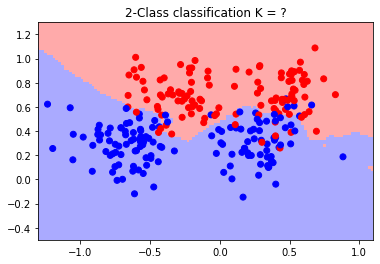

In [ ]:
# Performing K-Nearest Neighbors
score_temp = 0
y_train = np.ravel(y_train)
for K in range(5,20):
  K = K + 1
  knn = neighbors.KNeighborsClassifier(n_neighbors=K, weights="distance", p=2)
  knn.fit(X_train, y_train)
  score = knn.score(X_val, y_val)
  if score > score_temp:
    score_temp = score
    K_best = K

print("Best K is: " + str(K_best))
print("Validation Accuracu is: " + str(score))
score_train = clf.score(X_train, y_train)
print("K-Nearest Neighbors")
print("- Best K is: " + str(K_best))
print("- Training Accuracy is: " + str(score_train))
print("- Validation Accuracy is: " + str(score))

# Evaluating Model On Test Data
clf = neighbors.KNeighborsClassifier(n_neighbors=K_best, weights='distance')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_test = np.ravel(y_test)
score_test = clf.score(X_test, y_test)
print("- Test Accuracy is: " + str(score_test))

# Vizualizing Best KNN Model
h = 0.02 # step size for the mesh

cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])


# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors=K_best, weights='distance')
clf.fit(X_train, y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(-1.3, 1.1)
plt.ylim(-0.5, 1.3)
plt.title("2-Class classification K = ?")

plt.show()

In [ ]:
## Part b: High Dimensional Dataset ##

# Generating Dataset
n_train = 50
n_val = 50
n_test = 1000
n_tot = n_train + n_val + n_test

hyper_cube_dim = 20

X = np.random.uniform(0, 1, (n_tot, hyper_cube_dim))
y = np.zeros(n_tot,)
for i in range(0, X.shape[0]):
  if X[i,1]+X[i,3]+X[i,5]+X[i,7]+X[i,9]+X[i,11]+X[i,13]+X[i,15]+X[i,17]+X[i,9] > 5:
    y[i] = 1
  else:
    y[i] = -1

# Splitting into training, validation, and testing sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=1000, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.5, random_state=69)

In [ ]:
# Performing SVC Poly
degree_vals = [1,2,3,4]
C_vals = [2e-5, 2e-4, 2e-3, 2e-2, 2e-1, 2e0]
gamma_vals = [1, 5, 10, 20, 30]
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
score_temp = 0
C_best = 0
gamma_best = 0
degree_best = 0
for m in range(0, len(degree_vals)):
  for i in range(0, len(C_vals)):
    for j in range(0, len(gamma_vals)):
      params = {'C': C_vals[i], 'gamma': gamma_vals[j], 'degree': degree_vals[m]}
      clf = SVC(kernel='poly', **params)
      clf = clf.fit(X_train, y_train)
      score = clf.score(X_val, y_val)
      if score > score_temp:
        score_temp = score
        degree_best = degree_vals[m]
        C_best = C_vals[i]
        gamma_best = gamma_vals[j]
      else:
        continue

y_pred = clf.predict(X_test)
y_test = np.ravel(y_test)
score_training = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
print("Polynomial SVM")
print("- Optimal degree is: " + str(degree_best))
print("- Optimal C is: " + str(C_best))
print("- Optimal gamma is: " + str(gamma_best))
print("- Training Accuracy: " +str(score_training))
print("- Validation Accuracy: " +str(score))
print("- Test Accuracy is: " + str(score_test))

# Performing K-Nearest Neighbors
score_temp = 0
y_train = np.ravel(y_train)
for K in range(5,20):
  K = K + 1
  knn = neighbors.KNeighborsClassifier(n_neighbors=K, weights="distance", p=2)
  knn.fit(X_train, y_train)
  score = knn.score(X_val, y_val)
  if score > score_temp:
    score_temp = score
    K_best = K

score_train = clf.score(X_train, y_train)

print("K-Nearest Neighbors")
print("- Best K is: " + str(K_best))
print("- Training Accuracy is: " + str(score_train))
print("- Validation Accuracy is: " + str(score))

# Evaluating Model On Test Data
clf = neighbors.KNeighborsClassifier(n_neighbors=K_best, weights='distance')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_test = np.ravel(y_test)
score_test = clf.score(X_test, y_test)
print("- Test Accuracy is: " + str(score_test))

Polynomial SVM
- Optimal degree is: 3
- Optimal C is: 2e-05
- Optimal gamma is: 10
- Training Accuracy: 1.0
- Validation Accuracy: 0.88
- Test Accuracy is: 0.815
K-Nearest Neighbors
- Best K is: 7
- Training Accuracy is: 1.0
- Validation Accuracy is: 0.68
- Test Accuracy is: 0.684


# Problem 4 (Small Dataset)

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow import keras

# Loading Handwritten Digits Dataset
mnist = tf.keras.datasets.mnist

# Separating Into Training and Testing Sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

n_train = 20
n_val = 20
n_test = 2000
n_train_5 = 0
n_train_8 = 0
n_val_5 = 0
n_val_8 = 0
n_test_5 = 0
n_test_8 = 0
x_train_5and8 = []
y_train_5and8 = []
x_val_5and8 = []
y_val_5and8 = []
x_test_5and8 = []
y_test_5and8 = []
for i in range(0, len(y_train)):
  # Generating Training Data
  if n_train_5 + n_train_8 <= n_train:
    if y_train[i] == 5:
      if n_train_5 < 10:
        y_train_5and8.append(y_train[i])
        x_train_5and8.append(x_train[i,:])
        n_train_5 = n_train_5 + 1
      else:
        continue
    elif y_train[i] == 8:
      if n_train_8 < 10:
        y_train_5and8.append(y_train[i])
        x_train_5and8.append(x_train[i,:])
        n_train_8 = n_train_8 + 1
      else:
        continue
  else:
    continue
  # Generating Validation Data
  if n_val_5 + n_val_8 <= n_val:
    if y_train[i] == 5:
      if n_val_5 < 10:
        y_val_5and8.append(y_train[i])
        x_val_5and8.append(x_train[i,:])
        n_val_5 = n_val_5 + 1
      else:
        continue
    elif y_train[i] == 8:
      if n_val_8 < 10:
        y_val_5and8.append(y_train[i])
        x_val_5and8.append(x_train[i,:])
        n_val_8 = n_val_8 + 1
      else:
        continue
  else:
      continue
  # Generating Test Data (Additional data needed from training set since not 2000 samples in test set like problem asks for)
  if n_test_5 + n_test_8 <= n_test:
    if y_train[i] == 5:
      if n_test_5 < 1000:
        y_test_5and8.append(y_train[i])
        x_test_5and8.append(x_train[i,:])
        n_test_5 = n_test_5 + 1
      else:
        continue
    elif y_train[i] == 8:
      if n_test_8 < 1000:
        y_test_5and8.append(y_train[i])
        x_test_5and8.append(x_train[i,:])
        n_test_8 = n_test_8 + 1
      else:
        continue
  else:
      continue

for i in range(0, len(y_test)):
  # Generating Test Data
  if n_test_5 + n_test_8 <= n_test:
    if y_test[i] == 5:
      if n_test_5 < 1000:
        y_test_5and8.append(y_test[i])
        x_test_5and8.append(x_test[i,:])
        n_test_5 = n_test_5 + 1
      else:
        continue
    elif y_test[i] == 8:
      if n_test_8 < 1000:
        y_test_5and8.append(y_test[i])
        x_test_5and8.append(x_test[i,:])
        n_test_8 = n_test_8 + 1
      else:
        continue
  else:
    continue

TypeError: ignored

In [ ]:
# SVM Binary Classification

x_train = np.asarray(x_train_5and8)
x_val = np.asarray(x_val_5and8)
x_test = np.asarray(x_test_5and8)
y_train = np.asarray(y_train_5and8)
y_val = np.asarray(y_val_5and8)
y_test = np.asarray(y_test_5and8)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

# Converting to 2d arrays for fit functions to work
def Threed_to_Twod(x):
  nsamples, nx1, nx2 = x.shape
  x_new= x.reshape((nsamples, nx1*nx2))
  return x_new

x_train = Threed_to_Twod(x_train)
x_val = Threed_to_Twod(x_val)
x_test = Threed_to_Twod(x_test)

# Scaling Data
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_val = ss.fit_transform(x_val)
x_test = ss.fit_transform(x_test)

C_vals = [2e-5, 2e-3]
gamma_vals = [1, 10]
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
score_temp = 0
C_best = 0
gamma_best = 0
for i in range(0, len(C_vals)):
  for j in range(0, len(gamma_vals)):
    params = {'C': C_vals[i], 'gamma': gamma_vals[j]}
    clf = SVC(kernel='rbf', **params)
    clf = clf.fit(x_train, y_train)
    score = clf.score(x_val, y_val)
    if score > score_temp:
      score_temp = score
      C_best = C_vals[i]
      gamma_best = gamma_vals[j]
    else:
      continue

# Getting results
params = {'C': C_best, 'gamma': gamma_best}
clf = SVC(kernel='rbf', **params)
clf = clf.fit(x_train, y_train)
y_test = np.ravel(y_test)
score_training = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print("Polynomial SVM")
print("Optimal C is: " + str(C_best))
print("Optimal gamma is: " + str(gamma_best))
print("- Training Accuracy: " +str(score_training))
print("- Validation Accuracy: " +str(score))
print("- Test Accuracy is: " + str(score_test))

(20, 28, 28)
(20, 28, 28)
(1886, 28, 28)
Polynomial SVM
Optimal C is: 2e-05
Optimal gamma is: 1
- Training Accuracy: 1.0
- Validation Accuracy: 1.0
- Test Accuracy is: 0.6749734888653235


In [ ]:
# Building Own Deep Learning Model

x_train = np.asarray(x_train_5and8)
x_val = np.asarray(x_val_5and8)
x_test = np.asarray(x_test_5and8)
y_train = np.asarray(y_train_5and8)
y_val = np.asarray(y_val_5and8)
y_test = np.asarray(y_test_5and8)

# Build Keras Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=20,
    decay_rate=.98)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=5)

model.evaluate(x_test, y_test)

Epoch 1/10
4/4 [==============================] - 1s 59ms/step - loss: 1.9578 - accuracy: 0.1000 - val_loss: 1.0332 - val_accuracy: 0.9000
Epoch 2/10
4/4 [==============================] - 0s 13ms/step - loss: 0.7743 - accuracy: 0.6500 - val_loss: 0.4728 - val_accuracy: 0.8500
Epoch 3/10
4/4 [==============================] - 0s 12ms/step - loss: 0.3683 - accuracy: 0.8500 - val_loss: 0.2930 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 0.2047 - accuracy: 1.0000 - val_loss: 0.0869 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 0.0760 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 0s 11ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 8/10
4/4 [===========

[0.5931984782218933, 0.8170731663703918]

# Problem 4 (Large Dataset)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

# Loading Handwritten Digits Dataset
mnist = tf.keras.datasets.mnist

# Separating Into Training and Testing Sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

n_train = 800
n_val = 800
n_test = 2000
n_train_5 = 0
n_train_8 = 0
n_val_5 = 0
n_val_8 = 0
n_test_5 = 0
n_test_8 = 0
x_train_5and8 = []
y_train_5and8 = []
x_val_5and8 = []
y_val_5and8 = []
x_test_5and8 = []
y_test_5and8 = []
for i in range(0, len(y_train)):
  # Generating Training Data
  if n_train_5 + n_train_8 <= n_train:
    if y_train[i] == 5:
      if n_train_5 < 400:
        y_train_5and8.append(y_train[i])
        x_train_5and8.append(x_train[i,:])
        n_train_5 = n_train_5 + 1
      else:
        continue
    elif y_train[i] == 8:
      if n_train_8 < 400:
        y_train_5and8.append(y_train[i])
        x_train_5and8.append(x_train[i,:])
        n_train_8 = n_train_8 + 1
      else:
        continue
  else:
    continue
  # Generating Validation Data
  if n_val_5 + n_val_8 <= n_val:
    if y_train[i] == 5:
      if n_val_5 < 400:
        y_val_5and8.append(y_train[i])
        x_val_5and8.append(x_train[i,:])
        n_val_5 = n_val_5 + 1
      else:
        continue
    elif y_train[i] == 8:
      if n_val_8 < 400:
        y_val_5and8.append(y_train[i])
        x_val_5and8.append(x_train[i,:])
        n_val_8 = n_val_8 + 1
      else:
        continue
  else:
      continue
  # Generating Test Data (Additional data needed from training set since not 2000 samples in test set like problem asks for)
  if n_test_5 + n_test_8 <= n_test:
    if y_train[i] == 5:
      if n_test_5 < 1000:
        y_test_5and8.append(y_train[i])
        x_test_5and8.append(x_train[i,:])
        n_test_5 = n_test_5 + 1
      else:
        continue
    elif y_train[i] == 8:
      if n_test_8 < 1000:
        y_test_5and8.append(y_train[i])
        x_test_5and8.append(x_train[i,:])
        n_test_8 = n_test_8 + 1
      else:
        continue
  else:
      continue

for i in range(0, len(y_test)):
  # Generating Test Data
  if n_test_5 + n_test_8 <= n_test:
    if y_test[i] == 5:
      if n_test_5 < 1000:
        y_test_5and8.append(y_test[i])
        x_test_5and8.append(x_test[i,:])
        n_test_5 = n_test_5 + 1
      else:
        continue
    elif y_test[i] == 8:
      if n_test_8 < 1000:
        y_test_5and8.append(y_test[i])
        x_test_5and8.append(x_test[i,:])
        n_test_8 = n_test_8 + 1
      else:
        continue
  else:
    continue

# Adding 5% data corruption (5% of data labels are misslabled)
n_train_corrupt = np.int(0.05 * n_train)
n_val_corrupt = np.int(0.05 * n_val)
n_test_corrupt = np.int(0.05 * n_test)

# Creating arrays of all indices in each dataset
train_len = np.arange(0,len(y_train_5and8))
val_len = np.arange(0,len(y_val_5and8))
test_len = np.arange(0,len(y_test_5and8))

# Selecing random indices to corrupt
train_ind = np.random.choice(train_len, size=n_train_corrupt, replace=False)
val_ind = np.random.choice(val_len, size=n_val_corrupt, replace=False)
test_ind = np.random.choice(test_len, size=n_test_corrupt, replace=False)

# Corrupting indices
for ind in train_ind:
  if y_train_5and8[ind] == 5:
    y_train_5and8[ind] = 8
  else:
    y_train_5and8[ind] = 5

for ind in val_ind:
  if y_val_5and8[ind] == 5:
    y_train_5and8[ind] = 8
  else:
    y_val_5and8[ind] = 5

for ind in test_ind:
  if y_test_5and8[ind] == 5:
    y_test_5and8[ind] = 8
  else:
    y_test_5and8[ind] = 5

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# SVM Binary Classification

x_train = np.asarray(x_train_5and8)
x_val = np.asarray(x_val_5and8)
x_test = np.asarray(x_test_5and8)
y_train = np.asarray(y_train_5and8)
y_val = np.asarray(y_val_5and8)
y_test = np.asarray(y_test_5and8)

# Converting to 2d arrays for fit functions to work
def Threed_to_Twod(x):
  nsamples, nx1, nx2 = x.shape
  x_new= x.reshape((nsamples, nx1*nx2))
  return x_new

x_train = Threed_to_Twod(x_train)
x_val = Threed_to_Twod(x_val)
x_test = Threed_to_Twod(x_test)

# Scaling Data
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_val = ss.fit_transform(x_val)
x_test = ss.fit_transform(x_test)

C_vals = [2e-5, 2e-3]
gamma_vals = [1, 10]
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)
score_temp = 0
C_best = 0
gamma_best = 0
for i in range(0, len(C_vals)):
  for j in range(0, len(gamma_vals)):
    params = {'C': C_vals[i], 'gamma': gamma_vals[j]}
    clf = SVC(kernel='rbf', **params)
    clf = clf.fit(x_train, y_train)
    score = clf.score(x_val, y_val)
    if score > score_temp:
      score_temp = score
      C_best = C_vals[i]
      gamma_best = gamma_vals[j]
    else:
      continue

# Getting results
params = {'C': C_best, 'gamma': gamma_best}
clf = SVC(kernel='rbf', **params)
clf = clf.fit(x_train, y_train)
y_test = np.ravel(y_test)
score_training = clf.score(x_train, y_train)
score_test = clf.score(x_test, y_test)
print("Polynomial SVM")
print("Optimal C is: " + str(C_best))
print("Optimal gamma is: " + str(gamma_best))
print("- Training Accuracy: " +str(score_training))
print("- Validation Accuracy: " +str(score))
print("- Test Accuracy is: " + str(score_test))

Polynomial SVM
Optimal C is: 2e-05
Optimal gamma is: 1
- Training Accuracy: 0.5275
- Validation Accuracy: 0.47875
- Test Accuracy is: 0.496


In [ ]:
## Using Deep Learning

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

# Batch and Shuffle Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Build Keras Model
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)
    

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

# Setting up optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Metrics to Measure the loss and accuracy of the model
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
# Training the model
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

# Testing the model
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

EPOCHS = 10

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.00604790635406971, Accuracy: 99.80833435058594, Test Loss: 0.06897608190774918, Test Accuracy: 98.20999908447266
Epoch 2, Loss: 0.005598744377493858, Accuracy: 99.8116683959961, Test Loss: 0.06875547021627426, Test Accuracy: 98.43000030517578
Epoch 3, Loss: 0.003935535438358784, Accuracy: 99.87166595458984, Test Loss: 0.08378487825393677, Test Accuracy: 98.33999633789062
Epoch 4, Loss: 0.004507048986852169, Accuracy: 99.84333801269531, Test Loss: 0.06918962299823761, Test Accuracy: 98.37999725341797
Epoch 5, Loss: 0.003353363135829568, Accuracy: 99.87666320800781, Test Loss: 0.08307429403066635, Test Accuracy: 98.30999755859375
Epoch 6, Loss: 0.002016935031861067, Accuracy: 99.9433364868164, Test Loss: 0.09052267670631409, Test Accuracy: 98.29999542236328
Epoch 7, Loss: 0.003858205396682024, Accuracy: 99.87166595458984, Test Loss: 0.0870935246348381, Test Accuracy: 98.33999633789062
Epoch 8, Loss: 0.002108908724039793, Accuracy: 99.92500305175781, Test Loss: 0.11397083

In [ ]:
# Building Own Deep Learning Model

x_train = np.asarray(x_train_5and8)
x_val = np.asarray(x_val_5and8)
x_test = np.asarray(x_test_5and8)
y_train = np.asarray(y_train_5and8)
y_val = np.asarray(y_val_5and8)
y_test = np.asarray(y_test_5and8)

# Build Keras Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.LeakyReLU()(x)
  tf.keras.layers.Dense(10, activation='softmax')
])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=5000,
    decay_rate=0.99)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks=[callback])

model.evaluate(x_test, y_test)

Epoch 1/10
25/25 [==============================] - 1s 11ms/step - loss: 0.8477 - accuracy: 0.7275 - val_loss: 0.2875 - val_accuracy: 0.9225
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3544 - accuracy: 0.8888 - val_loss: 0.2480 - val_accuracy: 0.9400
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2803 - accuracy: 0.9112 - val_loss: 0.2227 - val_accuracy: 0.9438
Epoch 4/10
25/25 [==============================] - 0s 5ms/step - loss: 0.2374 - accuracy: 0.9200 - val_loss: 0.2452 - val_accuracy: 0.9400
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 0.2249 - accuracy: 0.9225 - val_loss: 0.2435 - val_accuracy: 0.9425
Epoch 6/10
63/63 [==============================] - 0s 3ms/step - loss: 0.2977 - accuracy: 0.9110


[0.29769647121429443, 0.9110000133514404]

In [ ]:
print(x_train.shape)
print(x_test.shape)

(800, 28, 28)
(2000, 28, 28)
